In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
import librosa
import seaborn as sns
import sklearn.metrics
import h5py

Limited tf.compat.v2.summary API due to missing TensorBoard installation


Using TensorFlow backend.


In [2]:
dir_path = '/home/duh17/Desktop/free-spoken-digit-dataset/recordings/'
file_names = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) and '.wav' in f]

FileNotFoundError: [Errno 2] No such file or directory: '/home/duh17/Desktop/free-spoken-digit-dataset/recordings/'

In [2]:
def save_model(model) :
    model.save('MFCC.h5')

def load_model() :
    model = keras.models.load_model('MFCC.h5')
    return model

def load_from_wav(dir_path, file_names):
    lst = []
    for file_name in file_names :
    #     print(file_name)
        sample, sample_rate = librosa.load(dir_path+file_name, sr=8000)
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=24)
        lst.append([mfccs, file_name])
    return lst

# save and load data X, y
def input2file(X, Y):
    f = h5py.File('input.h5', 'w')
    f['X'] = X
    f['Y'] = Y
    f.close()

def file2input():
    f = h5py.File('input.h5', 'r')
    X = f['X'][:]
    Y = f['Y'][:]
    f.close()
    return X, Y

def truncateMFCC(inmfcc, maxlength) :
    """
    :inmfcc : input mfcc and file name
    :rtype: truncated mfcc
    """
    outmfcc = inmfcc[0][:,:3]
    return outmfcc

In [ ]:
'''
We have a pretrained model and input.
This Block will re-read the wav files. 
You can use :
X, Y = file2input()
to get the input directly.
''' 
# load wave from .wav file
lst = load_from_wav(dir_path, file_names)
temp = []
# We have 2000 wave files in total
for i in range(2000) :
    temp.append(lst[i][0].shape[1])
min_len_of_input = min(temp)
# lst[4][0][:,:3]

res = []
N_samples = 2000

for i in lst :
#     print(i)
    res.append([MFCC(i, min_len_of_input), i[1]])
# res

#use numpy.array to store X, Y for further process
X = []
Y = []
for i in res :
    X.append(i[0])
    Y.append(int(i[1][0]))
X = np.asarray(X)
tempY = np.asarray(Y)
# Create One-Hot encodings for Y
lsttmp = []
for i in tempY :
    tmp = []
    for numbers in range(10) :
        if numbers == i :
            num = 1
        else :
            num = 0
        tmp.append(num)
    lsttmp.append(tmp)
Y = np.asarray(lsttmp)
# resize X to meet the requirement of Layer Conv2D
X.resize(2000,24,3,1)
print("X: " + X.shape)
print("Y:" + Y.shape)

In [3]:
X, Y = file2input()

In [4]:
# Train and test set splition
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# X_train = X_train.reshape(1340, 8000, 1)

In [5]:
"""
We have trained a model and you can use load_model() and ignore morel.compile and model.fit to reload it if you just want to check the result.
model = load_model()
"""

# Keras layers settings
model = Sequential()
# model.add(Conv1D(filters=1, kernel_size=10, activation='relu', input_shape=(8000,)))
model.add(Conv2D(32,(2,2),     
                  input_shape=X_train.shape[1:],      
                  activation= 'relu',
                  padding='same')) 
# model.add(Dense(8000, activation='relu'))
#model.add(Conv2D(32, (2,2), padding='valid'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

W0308 01:42:00.316001 140523748828992 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# Keras training loss and optimization settings
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [7]:
# Model fit
history = model.fit(X_train,y_train, epochs=100, validation_split=0.2)

Train on 1072 samples, validate on 268 samples
Epoch 1/100
1072/1072 [==============================] - 3s 3ms/step - loss: 3.9702 - acc: 0.2099 - val_loss: 1.9289 - val_acc: 0.3358
Epoch 2/100
1072/1072 [==============================] - 0s 117us/step - loss: 1.9829 - acc: 0.3517 - val_loss: 1.6983 - val_acc: 0.3582
Epoch 3/100
1072/1072 [==============================] - 0s 105us/step - loss: 1.6387 - acc: 0.4552 - val_loss: 1.2254 - val_acc: 0.5709
Epoch 4/100
1072/1072 [==============================] - 0s 115us/step - loss: 1.3006 - acc: 0.5606 - val_loss: 0.8979 - val_acc: 0.6866
Epoch 5/100
1072/1072 [==============================] - 0s 107us/step - loss: 1.0778 - acc: 0.6185 - val_loss: 1.0120 - val_acc: 0.5821
Epoch 6/100
1072/1072 [==============================] - 0s 106us/step - loss: 0.8846 - acc: 0.6810 - val_loss: 1.7241 - val_acc: 0.4627
Epoch 7/100
1072/1072 [==============================] - 0s 111us/step - loss: 0.8278 - acc: 0.7108 - val_loss: 0.6092 - val_acc: 0.7

1072/1072 [==============================] - 0s 112us/step - loss: 0.0952 - acc: 0.9655 - val_loss: 0.2121 - val_acc: 0.9478
Epoch 61/100
1072/1072 [==============================] - 0s 115us/step - loss: 0.1175 - acc: 0.9618 - val_loss: 0.2253 - val_acc: 0.9440
Epoch 62/100
1072/1072 [==============================] - 0s 186us/step - loss: 0.0808 - acc: 0.9720 - val_loss: 0.3176 - val_acc: 0.9328
Epoch 63/100
1072/1072 [==============================] - 0s 111us/step - loss: 0.0882 - acc: 0.9701 - val_loss: 0.2420 - val_acc: 0.9552
Epoch 64/100
1072/1072 [==============================] - 0s 130us/step - loss: 0.0694 - acc: 0.9757 - val_loss: 0.2197 - val_acc: 0.9478
Epoch 65/100
1072/1072 [==============================] - 0s 161us/step - loss: 0.0910 - acc: 0.9711 - val_loss: 0.2257 - val_acc: 0.9478
Epoch 66/100
1072/1072 [==============================] - 0s 108us/step - loss: 0.0933 - acc: 0.9692 - val_loss: 0.2374 - val_acc: 0.9552
Epoch 67/100
1072/1072 [=======================

In [8]:
save_model(model)

In [9]:
# Model evaluation
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

660/660 [==============================] - 0s 45us/step


[0.1258857145256391, 0.95]

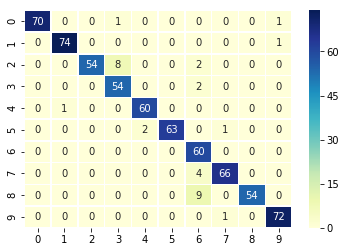

In [10]:
# Confusion Matrix
matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.savefig("confusion_heatgraph.png", dpi=600)

In [11]:
# Model Graph
from keras.utils import plot_model
plot_model(model, to_file='model.svg', show_shapes=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

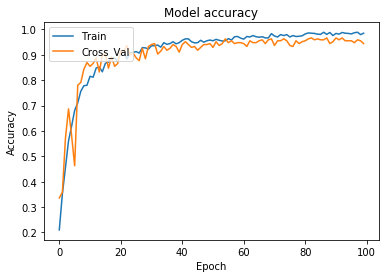

In [12]:
# accu plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross_Val'], loc='upper left')
plt.savefig("accuracy.png", dpi=600)
plt.show()

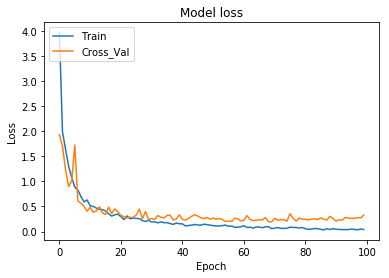

In [13]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross_Val'], loc='upper left')
plt.savefig("loss.png", dpi=600)
plt.show()

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
# roc_auc = sklearn.metrics.auc(fpr, tpr)
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

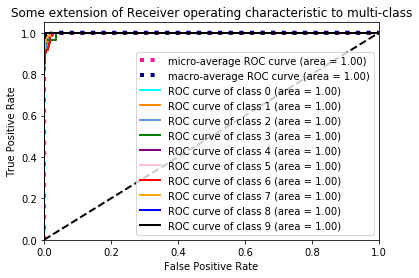

In [42]:
from scipy import interp
from sklearn.metrics import auc
from itertools import cycle
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 10

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple', 'pink', 'red', 'orange', 'blue', 'black'])
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("ROC.png", dpi=1000)
plt.show()